In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
import operator
import copy

{'SF': {0: 'no', 1: {'F': {0: {'WW': {0: {'SI': {0: 'yes', 1: 'no'}}, 2: 'yes'}}, 1: 'no', 2: {'C': {0: 'no', 1: 'yes', 2: 'no'}}}}, 2: {'D': {0: 'yes', 1: 'yes', 2: {'F': {0: 'no', 1: 'no', 2: {'C': {0: 'yes', 2: 'no'}}}}}}}}


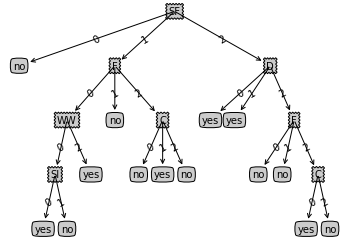

yes


In [14]:
from math import log
import operator
from matplotlib.font_manager import FontProperties


def calcShannonEnt(dataSet):
    #返回数据集行数
    numEntries=len(dataSet)
    #保存每个标签（label）出现次数的字典
    labelCounts={}
    #对每组特征向量进行统计
    for featVec in dataSet:
        currentLabel=featVec[-1]                     #提取标签信息
        if currentLabel not in labelCounts.keys():   #如果标签没有放入统计次数的字典，添加进去
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1                 #label计数

    shannonEnt=0.0                                   #经验熵
    #计算经验熵
    for key in labelCounts:
        prob=float(labelCounts[key])/numEntries      #选择该标签的概率
        shannonEnt-=prob*log(prob,2)                 #利用公式计算
    return shannonEnt                                #返回经验熵


data=pd.read_excel('因素打分.xlsx')
data=data.values.tolist()


def createDataSet():
    # 数据集
    dataSet=data
    #分类属性
    labels=['WW','F','C','SF','D','PA','SI']
    #返回数据集和分类属性
    return dataSet,labels


def splitDataSet(dataSet,axis,value):
    #创建返回的数据集列表
    retDataSet=[]
    #遍历数据集
    for featVec in dataSet:
        if featVec[axis]==value:
            #去掉axis特征
            reduceFeatVec=featVec[:axis]
            #将符合条件的添加到返回的数据集
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    #返回划分后的数据集
    return retDataSet

def chooseBestFeatureToSplit(dataSet):
    #特征数量
    numFeatures = len(dataSet[0]) - 1
    #计数数据集的香农熵
    baseEntropy = calcShannonEnt(dataSet)
    #信息增益
    bestInfoGain = 0.0
    #最优特征的索引值
    bestFeature = -1
    #遍历所有特征
    for i in range(numFeatures):
        # 获取dataSet的第i个所有特征
        featList = [example[i] for example in dataSet]
        #创建set集合{}，元素不可重复
        uniqueVals = set(featList)
        #经验条件熵
        newEntropy = 0.0
        #计算信息增益
        for value in uniqueVals:
            #subDataSet划分后的子集
            subDataSet = splitDataSet(dataSet, i, value)
            #计算子集的概率
            prob = len(subDataSet) / float(len(dataSet))
            #根据公式计算经验条件熵
            newEntropy += prob * calcShannonEnt((subDataSet))
        #信息增益
        infoGain = baseEntropy - newEntropy
        #打印每个特征的信息增益
        # print("第%d个特征的增益为%.3f" % (i, infoGain))
        #计算信息增益
        if (infoGain > bestInfoGain):
            #更新信息增益，找到最大的信息增益
            bestInfoGain = infoGain
            #记录信息增益最大的特征的索引值
            bestFeature = i
            #返回信息增益最大特征的索引值
    return bestFeature


def majorityCnt(classList):
    classCount={}
    #统计classList中每个元素出现的次数
    for vote in classList:
        if vote in classCount.keys():
            classCount[vote]=classCount.get(vote,0)+1
        #根据字典的值降序排列
        sortedClassCount=sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
        return sortedClassCount[0][0]

def createTree(dataSet,labels,featLabels):
    #取分类标签（是否匹配：yes or no）
    classList=[example[-1] for example in dataSet]
    #如果类别完全相同，则停止继续划分
    if classList.count(classList[0])==len(classList):
        return classList[0]
    #遍历完所有特征时返回出现次数最多的类标签
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    #选择最优特征
    bestFeat=chooseBestFeatureToSplit(dataSet)
    #最优特征的标签
    bestFeatLabel=labels[bestFeat]
    featLabels.append(bestFeatLabel)
    #根据最优特征的标签生成树
    myTree={bestFeatLabel:{}}
    #删除已经使用的特征标签
    del(labels[bestFeat])
    #得到训练集中所有最优特征的属性值
    featValues=[example[bestFeat] for example in dataSet]
    #去掉重复的属性值
    uniqueVls=set(featValues)
    #遍历特征，创建决策树
    for value in uniqueVls:
        myTree[bestFeatLabel][value]=createTree(splitDataSet(dataSet,bestFeat,value),
                                               copy.copy(labels),featLabels)
    return myTree

def getNumLeafs(myTree):
    numLeafs=0
    firstStr=next(iter(myTree))
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else: numLeafs+=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0                                               
    firstStr = next(iter(myTree))                                
    secondDict = myTree[firstStr]                                
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':                
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth            
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-")                                                 
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',    
        xytext=centerPt, textcoords='axes fraction',
        va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]                                           
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")                                        
    leafNode = dict(boxstyle="round4", fc="0.8")                                           
    numLeafs = getNumLeafs(myTree)                                                          
    depth = getTreeDepth(myTree)                                                            
    firstStr = next(iter(myTree))                                                           
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)    
    plotMidText(cntrPt, parentPt, nodeTxt)                                                    
    plotNode(firstStr, cntrPt, parentPt, decisionNode)                                       
    secondDict = myTree[firstStr]                                                            
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD                                        
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':                                            
            plotTree(secondDict[key],cntrPt,str(key))                                        
        else:                                                                                
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

# def classify(inputTree,featLabels,testVec):
#     #获取决策树节点
#     firstStr=next(iter(inputTree))
#     print(firstStr)
#     #下一个字典
#     secondDict=inputTree[firstStr]
#     print(secondDict)
#     featIndex=featLabels.index(firstStr)
#     for key in secondDict.keys():
#         if(featIndex>=len(testVec)):
#             if(type(secondDict[key]).__name__!='dict'):
#                 classLabel=secondDict[key]
#         else:
#             if testVec[featIndex]==key:
#                 if type(secondDict[key]).__name__=='dict':
#                     classLabel=classify(secondDict[key],featLabels,testVec)
#                 else: classLabel=secondDict[key]
#     return classLabel
def classify(inputTree,testVec):
    i=0
    while(type(inputTree).__name__=='dict'):
        #获取决策树节点
        firstStr=next(iter(inputTree))
        #下一个字典
        inputTree=inputTree[firstStr][testVec[i]]
        i=i+1
    return inputTree

if __name__=='__main__':
    dataSet,labels=createDataSet()
    featLabels=[]
    myTree=createTree(dataSet,labels,featLabels)
    print(myTree)
    createPlot(myTree)
    #测试数据
    testVec=[2,0,0]
    result=classify(myTree,testVec)
    print(result)
